In [31]:
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten, BatchNormalization, Lambda
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape+(1,)) / 255.0
x_test  = x_test.reshape(x_test.shape+(1,)) / 255.0

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test,  10)

n2l = {0: 'T-shirt/top',
       1: 'Trouser',
       2: 'Pullover',
       3: 'Dress',
       4: 'Coat',
       5: 'Sandal',
       6: 'Shirt',
       7: 'Sneaker',
       8: 'Bag',
       9: 'Ankle boot'}

In [35]:
def BN(net):
    return BatchNormalization(momentum=0.9)(net)


input_ae = Input(shape=x_train.shape[1:])
net = input_ae
net = BN(net)
net = Conv2D(16, 3, activation='relu', padding='same')(net)
net = MaxPooling2D(2, padding='same')(net)
net = BN(net)
net = Conv2D(32, 3, activation='relu', padding='same')(net)
net = MaxPooling2D(2, padding='same')(net)
net = BN(net)
net = Conv2D(64, 3, activation='relu', padding='same')(net)
net = Flatten()(net)
net = Dense(49)(net)
encoded = net
net = Reshape((7, 7, 1))(net)
net = BN(net)
net = Conv2D(64, 3, activation='relu', padding='same')(net)
net = UpSampling2D(2)(net)
net = BN(net)
net = Conv2D(32, 3, activation='relu', padding='same')(net)
net = UpSampling2D(2)(net)
net = BN(net)
output_ae = Conv2D(1, 3, activation='sigmoid', padding='same', name='ae')(net)

net = encoded
net = Lambda(lambda x: K.stop_gradient(x))(net)
net = Dense(128, activation='relu')(net)
output_clf = Dense(y_train.shape[-1], activation='softmax', name='clf')(net)

model = Model(input_ae, [output_ae, output_clf])
model.compile(optimizer='adam', 
              loss={'ae':  'mse',
                    'clf': 'binary_crossentropy'},
              metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 28, 28, 1)    4           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 28, 28, 16)   160         batch_normalization_37[0][0]     
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 14, 14, 16)   0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [36]:
model.fit(x_train, [x_train, y_train],
          epochs=20,
          batch_size=128,
          shuffle=True,
          validation_data=(x_test, [x_test, y_test]),
          verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 12s - loss: 0.1573 - ae_loss: 0.0283 - clf_loss: 0.1290 - ae_acc: 0.5032 - clf_acc: 0.9488 - val_loss: 0.1143 - val_ae_loss: 0.0167 - val_clf_loss: 0.0976 - val_ae_acc: 0.5053 - val_clf_acc: 0.9598
Epoch 2/20
 - 10s - loss: 0.0994 - ae_loss: 0.0147 - clf_loss: 0.0847 - ae_acc: 0.5079 - clf_acc: 0.9655 - val_loss: 0.0963 - val_ae_loss: 0.0135 - val_clf_loss: 0.0828 - val_ae_acc: 0.5059 - val_clf_acc: 0.9674
Epoch 3/20
 - 10s - loss: 0.0877 - ae_loss: 0.0128 - clf_loss: 0.0749 - ae_acc: 0.5084 - clf_acc: 0.9701 - val_loss: 0.0922 - val_ae_loss: 0.0128 - val_clf_loss: 0.0794 - val_ae_acc: 0.5060 - val_clf_acc: 0.9681
Epoch 4/20
 - 10s - loss: 0.0823 - ae_loss: 0.0119 - clf_loss: 0.0704 - ae_acc: 0.5085 - clf_acc: 0.9719 - val_loss: 0.0840 - val_ae_loss: 0.0112 - val_clf_loss: 0.0727 - val_ae_acc: 0.5064 - val_clf_acc: 0.9718
Epoch 5/20
 - 10s - loss: 0.0789 - ae_loss: 0.0113 - clf_loss: 0.0675 - ae_acc: 0.5086 - clf_acc: 0.97

In [37]:
p_img, p_clf = model.predict(x_test)

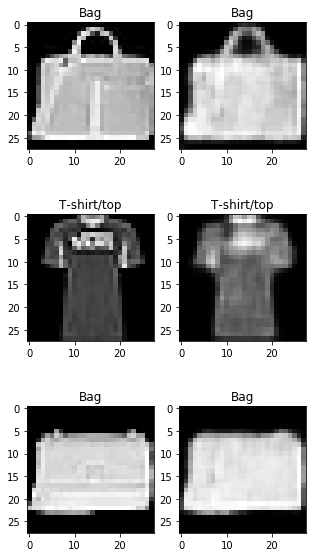

In [49]:
n_samples = 3

fig, axs = plt.subplots(n_samples, 2, figsize=(5,10))
for idx, sample_id in enumerate(np.random.randint(0, len(p_img), n_samples)):
    ax_img = axs[idx][0]
    ax_pre = axs[idx][1]
    ax_img.imshow(x_test[sample_id, ..., 0], cmap='gray')
    ax_img.set_title(n2l[np.argmax(y_test[sample_id])])
    ax_pre.imshow(p_img[sample_id, ..., 0], cmap='gray')
    ax_pre.set_title(n2l[np.argmax(p_clf[sample_id])])